# Correlation: Distances - Feature Importance

We observed, that the random forest predictor is sensitive to specific epitope positions, that are in close proximity to the CDR3 in the TCR. Let's quantify this.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Distances

Calculate the average distances to each epitope position based on the 3D model created with TCRpMHCmodels 1.0 from the full receptorr and epitope sequence.

In [2]:
path_distances = 'Output/features/distances_SIINFEKL.csv'
df_distances = pd.read_csv(path_distances, index_col=0)
df_distances.head()

,features_alpha,features_beta
B10,"22.37471280620683,19.605202188139476,16.752810...","30.065579525742255,26.798206138904693,25.60129..."
B11,"22.66134290589852,19.963202212662306,16.810194...","29.556694650946824,26.230716868216643,25.29436..."
B13,"23.055718694541863,20.266017261300053,16.07493...","29.98517019591422,26.756179346368597,25.697666..."
B14,"23.323002309876163,20.10385754014805,16.804973...","30.22697262484288,26.649404452094572,26.002235..."
B15,"22.983889447017983,20.40675512122189,17.410218...","30.494359131199886,26.670454940293773,25.33920..."


In [3]:
def extract_epitope_distances_per_tcr(distance_string):
    features = [float(d) for d in distance_string.split(',')]
    y = 8
    x = int(len(features)/y)
    features = np.array(features)
    features = np.reshape(features, newshape=(y, x))
    
    min_dist_epitope = np.min(features, axis=1)
    return min_dist_epitope

In [4]:
min_dists_alpha = []
min_dists_beta = []

for tcr in df_distances.index:
    if not (tcr.startswith('Ed') or tcr == 'OT1'):
        continue
    dist_alpha = extract_epitope_distances_per_tcr(df_distances['features_alpha'][tcr])
    min_dists_alpha.append(dist_alpha)
    
    dist_beta = extract_epitope_distances_per_tcr(df_distances['features_beta'][tcr])
    min_dists_beta.append(dist_beta)

min_dists_alpha = np.stack(min_dists_alpha).T
min_dists_beta = np.stack(min_dists_beta).T

In [5]:
min_dists_joint = np.stack([min_dists_alpha, min_dists_beta])
min_dists_joint = np.min(min_dists_joint, axis=0)

In [6]:
def plot_heatmap(data, title, labels, ticks, annot=False, vmax=20, vmin=0, center=0):
    plt.figure(figsize=(15, 8))
    plot = sns.heatmap(data, center=center, linewidths=0.5, cmap='RdBu_r', square=True, vmax=vmax, vmin=vmin, annot=annot)
    
    plot.set_title(title)
    plot.set(xlabel=labels[0], ylabel=labels[1])
    
    if ticks[0] is not None:
        plot.set_xticklabels(ticks[0])
    if ticks[1] is not None:
        plot.set_yticklabels(ticks[1])           

    plt.show()

Alpha


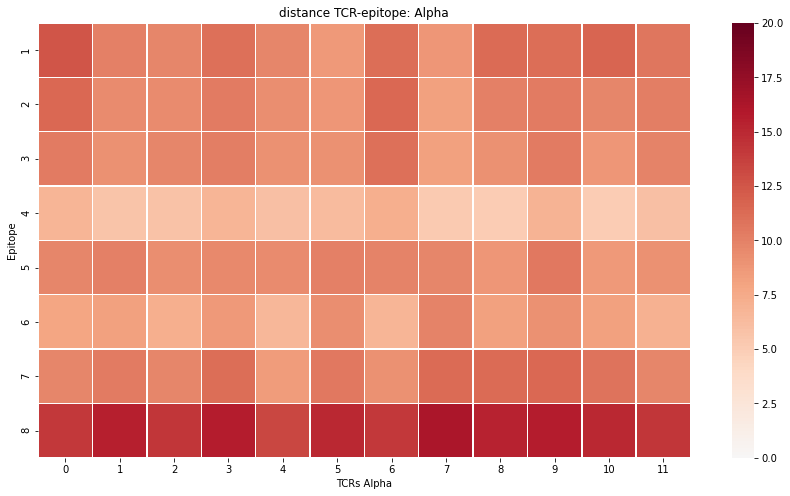

Beta


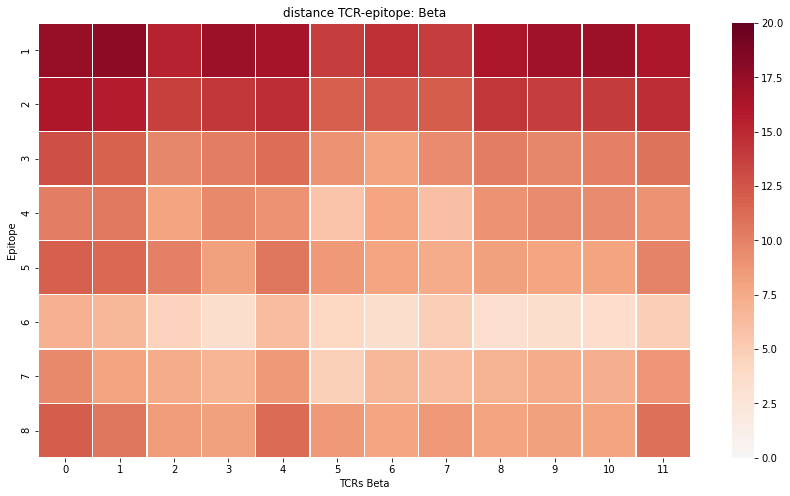

Joint


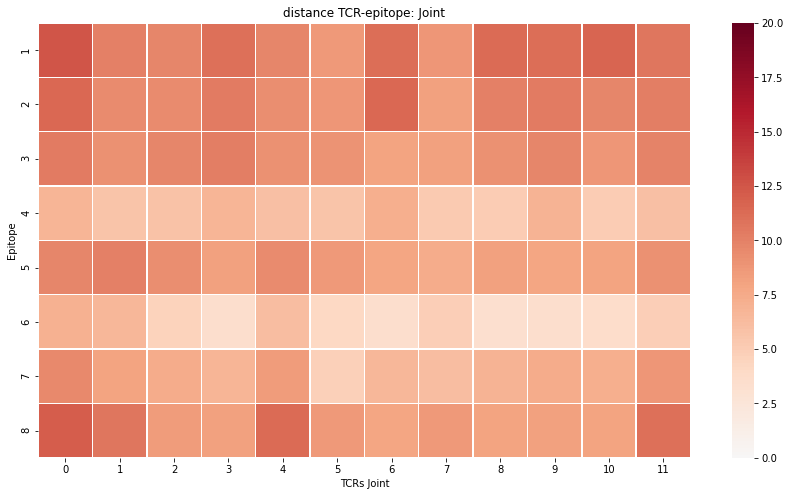

In [7]:
for dists, name in zip([min_dists_alpha, min_dists_beta, min_dists_joint], ['Alpha', 'Beta', 'Joint']):
    print(name)
    plot_heatmap(dists, f'distance TCR-epitope: {name}', [f'TCRs {name}', 'Epitope'], [None, list(range(1, 9))])

Alpha


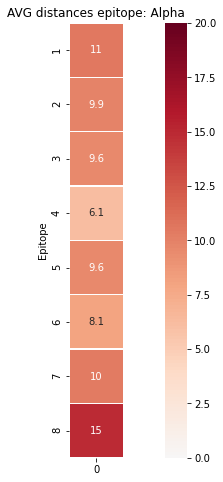

Beta


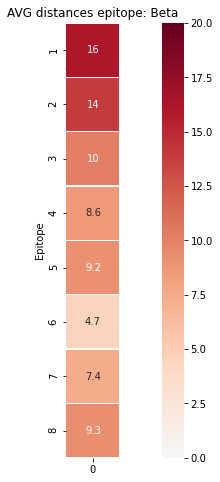

Joint


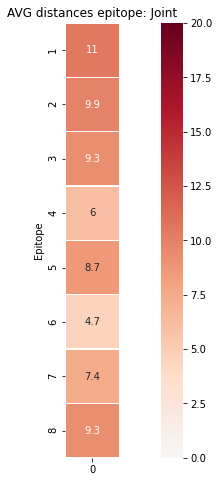

In [8]:
avg_alpha = np.mean(min_dists_alpha, axis=1).reshape((-1, 1))
avg_beta = np.mean(min_dists_beta, axis=1).reshape((-1, 1))
avg_joint = np.mean(min_dists_joint, axis=1).reshape((-1, 1))

for dists, name in zip([avg_alpha, avg_beta, avg_joint], ['Alpha', 'Beta', 'Joint']):
    print(name)
    plot_heatmap(dists, f'AVG distances epitope: {name}', ['', 'Epitope'], [None, list(range(1, 9))], annot=True)

## Feature Importance

In [9]:
from sklearn.metrics import (average_precision_score, precision_recall_curve, roc_auc_score, roc_curve)

In [10]:
path_importance = '../activation-prediction/results/tcr_stratified_permutation_importance.csv.gz'
pdf = pd.read_csv(path_importance, compression='gzip')

In [11]:
mdf = pdf[pdf['tcr'].isin(
    pdf[pdf['is_activated'] > 0.5]['tcr'].unique()
)].groupby(['tcr', 'group', 'shuffle']).apply(lambda q: pd.Series({
    'auc': roc_auc_score(q['is_activated'], q['pred']),
    'aps': average_precision_score(q['is_activated'], q['pred']),
    #'spearman': stats.spearmanr(q['activation'], q['pred'])[0],
})).reset_index().drop(columns='shuffle')
ddf = mdf.melt(['tcr', 'group']).merge(
    mdf[
        mdf['group'] == 'all'
    ].drop(columns='group').melt('tcr', value_name='base').drop_duplicates(),
    on=['tcr', 'variable']
)
ddf['diff'] = ddf['value'] - ddf['base']
ddf['rel'] = ddf['value'] / ddf['base'] - 1  # positive = increase
ddf['item'] = ddf['group'].str.split('_').str[0]
ddf['is_educated'] = ddf['tcr'].str.startswith('ED')
ddf = ddf[ddf['item'] == 'pos']
ddf = ddf[ddf['variable'] == 'auc']
ddf = ddf[ddf['is_educated'] == True]
ddf

,tcr,group,variable,value,base,diff,rel,item,is_educated
960,ED10,pos_0,auc,0.946863,0.907941,0.038922,0.042868,pos,True
961,ED10,pos_0,auc,0.946863,0.907941,0.038922,0.042868,pos,True
962,ED10,pos_0,auc,0.944314,0.907941,0.036373,0.040060,pos,True
963,ED10,pos_0,auc,0.945000,0.907941,0.037059,0.040816,pos,True
964,ED10,pos_0,auc,0.939608,0.907941,0.031667,0.034877,pos,True
...,...,...,...,...,...,...,...,...,...
3595,ED9,pos_7,auc,0.903536,0.905025,-0.001488,-0.001644,pos,True
3596,ED9,pos_7,auc,0.903186,0.905025,-0.001838,-0.002031,pos,True
3597,ED9,pos_7,auc,0.907651,0.905025,0.002626,0.002902,pos,True
3598,ED9,pos_7,auc,0.910102,0.905025,0.005077,0.005610,pos,True


In [12]:
feature_importances = []
for pos in ddf['group'].unique():
    imp = np.mean(ddf[ddf['group']==pos]['value'].values)
    feature_importances.append(imp)
feature_importances = np.array(feature_importances).reshape((-1, 1))
feature_importances

array([[0.87921469],
       [0.86798719],
       [0.88958029],
       [0.78385278],
       [0.88521488],
       [0.81665715],
       [0.87679096],
       [0.8845276 ]])

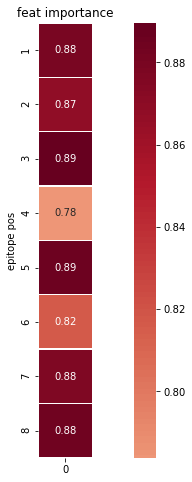

In [13]:
plot_heatmap(feature_importances, 'feat importance', ['', 'epitope pos'], [None, list(range(1, 9))], 
             annot=True, vmin=None, vmax=None, center=0.7)

## Correlation

In [14]:
def create_corr_dataframe(data_1, data_2, name_1, name_2):
    df_dict = {
        name_1: data_1[:, 0],
        name_2: data_2[:, 0]
    }
    df = pd.DataFrame(df_dict, index= list(range(1, len(data_1)+1)))
    return df

In [15]:
df_alpha_imp = create_corr_dataframe(feature_importances, avg_alpha, 'importance', 'distance')
df_beta_imp = create_corr_dataframe(feature_importances, avg_beta, 'importance', 'distance')
df_joint_imp = create_corr_dataframe(feature_importances, avg_joint, 'importance', 'distance')

In [16]:
df_joint_imp

,importance,distance
1,0.879215,10.544386
2,0.867987,9.906768
3,0.889580,9.295570
4,0.783853,6.035286
5,0.885215,8.675937
6,0.816657,4.662379
7,0.876791,7.375354
8,0.884528,9.300225


In [17]:
corr = df_joint_imp.corr(method='pearson')
corr_val = corr['importance']['distance']
corr

,importance,distance
importance,1.000000,0.787999
distance,0.787999,1.000000


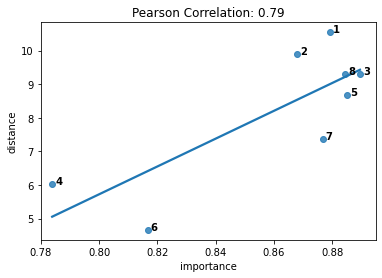

In [18]:
plot = sns.regplot(data=df_joint_imp, ci=None, x='importance', y='distance')
plot.set_title(f'Pearson Correlation: {corr_val:.2f}')

for line in range(1 ,df_joint_imp.shape[0]+1):
     plt.text(df_joint_imp.importance[line]+0.001, df_joint_imp.distance[line], line, horizontalalignment='left', size='medium', color='black', weight='semibold')


#plt.ylim(0, 1)
plt.xlim(0.78, 0.895)

#plot.plot((0, 1), (0, 1), 'r--')

#plt.show()
plt.savefig('../activation-prediction/figures/correlation_distances_importance.png', dpi=300)
plt.savefig('../activation-prediction/figures/correlation_distances_importance.pdf', dpi=300)